In [7]:
import gym
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

In [8]:
DISCOUNT_RATE = 0.9

In [9]:
def build_state(features):
  return int("".join(map(lambda feature: str(int(feature)), features)))

In [10]:
def to_bin(value, bins):
  return np.digitize(x=[value], bins=bins)[0]

In [11]:
class FeatureTransformer:
  def __init__(self):
    self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
    self.cart_velocity_bins = np.linspace(-2, 2, 9)
    self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
    self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9)

  def transform(self, observation):
    cart_pos, cart_vel, pole_angle, pole_vel = observation
    return build_state([
        to_bin(cart_pos, self.cart_position_bins),
        to_bin(cart_vel, self.cart_velocity_bins),
        to_bin(pole_angle, self.pole_angle_bins),
        to_bin(pole_vel, self.pole_velocity_bins)
    ])

In [12]:
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.feature_transformer = feature_transformer

    num_states = 10 ** env.observation_space.shape[0]
    num_actions = env.action_space.n
    self.q_table = np.random.uniform(-1, 1, size=(num_states, num_actions))

  def predict(self, state):
    x = self.feature_transformer.transform(state)
    return self.q_table[x]

  def update(self, state, action, return_):
    x = self.feature_transformer.transform(state)
    self.q_table[x, action] += 0.01 * (return_ - self.q_table[x, action])

  def epsilon_greedy(self, state, epsilon):
    if np.random.random() < epsilon:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(state))

In [13]:
def play_one_episode(model, epsilon):
  state = model.env.reset()
  done = False
  total_reward = 0
  iters = 0
  while not done and iters < 10000:
    action = model.epsilon_greedy(state, epsilon)
    next_state, reward, done, info = model.env.step(action)
    total_reward += reward

    if done and iters < 199:
      reward = -300

    return_ = reward + DISCOUNT_RATE * np.max(model.predict(state))
    model.update(state, action, return_)

    iters += 1
    state = next_state

  return total_reward

In [14]:
def plot_running_avg(total_rewards):
  running_avg = np.empty(len(total_rewards))
  for t in range(len(total_rewards)):
    running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Avg")
  plt.show();

Episode: 0 , Total Reward: 66.0 , Epsilon: 1.0
Episode: 100 , Total Reward: 61.0 , Epsilon: 0.09950371902099892
Episode: 200 , Total Reward: 9.0 , Epsilon: 0.07053456158585983
Episode: 300 , Total Reward: 16.0 , Epsilon: 0.0576390417704235
Episode: 400 , Total Reward: 17.0 , Epsilon: 0.04993761694389223
Episode: 500 , Total Reward: 106.0 , Epsilon: 0.04467670516087703
Episode: 600 , Total Reward: 12.0 , Epsilon: 0.04079085082240021
Episode: 700 , Total Reward: 23.0 , Epsilon: 0.0377694787300249
Episode: 800 , Total Reward: 18.0 , Epsilon: 0.03533326266687867
Episode: 900 , Total Reward: 38.0 , Epsilon: 0.03331483023263848
Episode: 1000 , Total Reward: 10.0 , Epsilon: 0.0316069770620507
Episode: 1100 , Total Reward: 95.0 , Epsilon: 0.03013743873394561
Episode: 1200 , Total Reward: 11.0 , Epsilon: 0.028855492841238062
Episode: 1300 , Total Reward: 11.0 , Epsilon: 0.027724348650071385
Episode: 1400 , Total Reward: 16.0 , Epsilon: 0.02671658425726324
Episode: 1500 , Total Reward: 14.0 , Ep

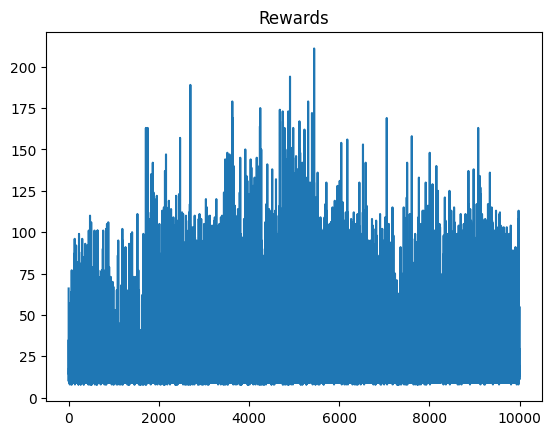

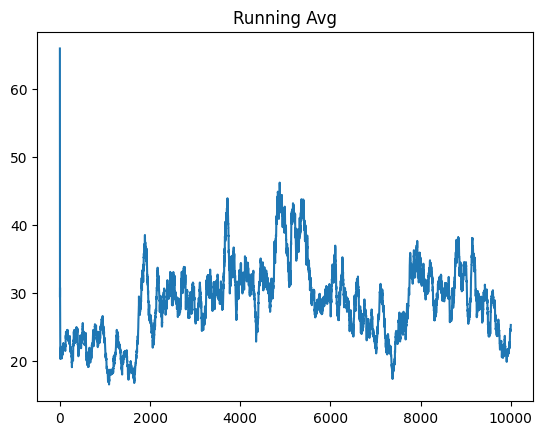

In [16]:
if __name__ == "__main__":
  env = gym.make("CartPole-v1")
  feature_transformer = FeatureTransformer()
  model = Model(env, feature_transformer)

  num_episodes = 10000
  total_rewards = np.empty(num_episodes)
  for n in range(num_episodes):
    epsilon = 1.0 / np.sqrt(n + 1)
    total_reward = play_one_episode(model, epsilon)
    total_rewards[n] = total_reward
    if n % 100 == 0:
      print("Episode:", n, ", Total Reward:", total_reward, ", Epsilon:", epsilon)

  print("Avg reward for last 100 episodes:", total_rewards[-100:].mean())
  print("Total Steps:", total_rewards.sum())

  plt.plot(total_rewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(total_rewards)